# Exercise 1: Feature Detection, Feature Descriptors and Feature Matching

In this exercise you will:
- Learn what features are and why they are important.
- Understand the concepts behind Harris Corner Detection.
- Use the OpenCV function [cv.cornerHarris()](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345).
- Learn about the concepts of the SIFT algorithm
- Learn to find SIFT Keypoints and Descriptors.
- Learn how to match SIFT features in one image with another.

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Features

https://docs.opencv.org/4.6.0/df/d54/tutorial_py_features_meaning.html

A feature is a pattern in an image that is unique, easily tracked and easily compared (detectable, localizable and describable). We need good features that can be compared across several images.

Even though humans easily can find such features in images, it's hard to describe how the human brain does it. But if we examine pictures, in general, and search for different patterns, we will find something interesting. For example, consider the image below:

<img width="500" height="500" src="../notebook_images/feature_building.jpg">

At the top of the image, six small image patches are given.
- A and B are flat surfaces, and they are spread over a lot of area in the image. It's difficult to find the exact location of these patches.
- C and D are much simpler. They are edges of the building. You can find an approximate location, but the exact location is still difficult. This is because the pattern is the same everywhere along the edge. An edge is a better feature compared to flat area, but not good enough.
- Finally, E and F are corners of the building. They can be easily located, since, wherever you move this patch, it will look different. Corners are therefore considered good features.

Let's look at a much simpler image below.

<img width="200" height="200" src="../notebook_images/feature_simple.png">

Just like above, the blue patch is a flat area and difficult to find and track. Wherever you move the blue patch, it looks the same. The black patch has an edge. If you move it in the vertical direction (i.e. along the gradient) it changes. But, moved along the edge (parallel to edge), it looks the same. The red patch is a corner. Wherever you move the patch, it looks different, i.e. it's unique.

How do we find these features? Well, we look for regions in an image that have maximum variation when shifted (by a small amount) in all directions around it, especially for corners.

Once features have been found in one image, we should be able to find a similar feature in another image. We accomplish this by describing our features, e.g. we take a region around the feature, explain it in our own words, like "the upper part is blue sky, the lower part is from a building, on that building there is glass, etc". Then we search for areas with the same description in other images. Basically, we are describing the feature. Similarly, a computer should be able to  describe the region around the feature, so called Feature Description (or Feature Descriptors), so that it can find it in other images, so called Feature Matching.

## Harris Corner Detection

https://docs.opencv.org/4.6.0/dc/d0d/tutorial_py_features_harris.html

As described above, corners are regions in the image with large variation in intensity in all the directions. One early attempt to find these corners was done by Chris Harris & Mike Stephens in their paper *A Combined Corner and Edge Detector* in 1988. The Harris corner detection algorithm basically finds the difference in intensity between a pixel and a displacement of (u,v) in all directions. This can be expressed as below:

$$
E(u,v) = \sum_{x, y} \quad \underbrace{ w(x,y) }_\text{window function} \quad [ \underbrace{ I(x+u, y+v) }_\text{shifted intensity} - \underbrace{ I(x,y) }_\text{intensity} ]^2
$$

The window function $w(x,y)$ is either a rectangular window or a Gaussian window which gives weights to pixels underneath.

We have to maximize this function E(u,v) for corner detection. That means we have to maximize the second term. Applying Taylor Expansion to the above equation and expressing the equation in vector form, we get the final equation as:

$$
E(u,v) =
\begin{bmatrix} u & v \end{bmatrix}
M
\begin{bmatrix} u \\ v \end{bmatrix}
$$

where

$$
M = \sum_{x, y} w(x,y)
\begin{bmatrix}
I_x I_x & I_x I_y \\
I_x I_y & I_y I_y
\end{bmatrix}
$$

Here, $I_x$ and $I_y$ are image derivatives in the x and y directions respectively. These can easily be found using [cv.Sobel()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d).

From this, the Harris response, a score that determines if a window contains an interesting feature or not, is defined as:

$$
R (x,y) =  det (M) - k  \left( tr (M) \right)^2
$$

where

- $ det(M) = \lambda_1 \lambda_2 $
- $ trace(M) = \lambda_1 + \lambda_2 $
- $\lambda_1$ and $\lambda_2$ are the eigenvalues of M.

The magnitudes of the eigenvalues decide whether a region is a corner, an edge, or flat.

- When $|R|$ is small, which happens when $\lambda_1$ and $\lambda_2$ are small, the region is flat.
- When $R<0$, which happens when $\lambda_1 >> \lambda_2$ or $\lambda_2 >> \lambda_1$, the region is an edge.
- When $R$ is large, which happens when $\lambda_1$ and $\lambda_2$ are large and $\lambda_1 \~ \lambda_1$, the region is a corner.

Thia can be illustrated in the picture below:

<img width="600" height="400" src="../notebook_images/harris.png">

The result of the Harris Corner Detection algorithm is a grayscale image with these scores. Thresholding for a suitable score gives you the corners in the image.

## Harris Corner Detector in OpenCV

OpenCV has the function [cv.cornerHarris()](https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345) for this purpose.

`cornerHarris(src, blockSize, ksize, k[, dst[, borderType]]) -> dst`
- `src` is a single-channel 8-bit of floating-point image.
- `blockSize` is the Neighborhood size.
- `ksize` is the Aperture parameter (kernel size) for the Sobel operator.
- `k` is the Harris detector free parameter.
- `borderType` is the Pixel extrapolation method, e.g. `cv.BORDER_REFLECT`

The function returns the image with the Harris Detector response scores in `dst`.

$$
\texttt{dst} (x,y) =  \mathrm{det} (M) - k  \cdot \left( \mathrm{tr} (M) \right)^2
$$

Let's try this out on an image with plenty of corners.

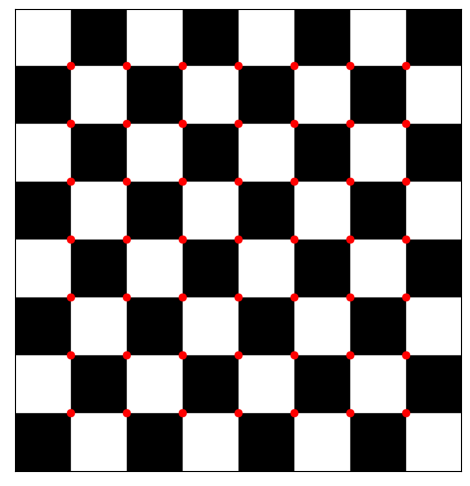

In [2]:
# Load an image and convert it to grayscale, float32
img = cv.imread('../data/chessboard.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

# Run the Harris Corner algorithm to get an array of lambda_min
blockSize = 2  # neighbourhood
kernelSize = 3 # sobel kernel
k = 0.04       # Harris Detector free parameter
dst = cv.cornerHarris(gray, blockSize, kernelSize, k)

# Result is dilated (pixels made "bigger")
# for marking the corners (not important for corner detection)
dst = cv.dilate(dst, None)

# Threshold for an optimal value (lambda_min) > threshold
# (it may vary depending on the image).
threshold = 0.01 * dst.max()
img[dst > threshold] = [0,0,255] # color detected corner pixels red

# Draw a red circle around each corner (easier to see).
i,j = np.where(dst > threshold)
for k in range(len(i)):
    # image, center, radius, color, thickness
    cv.circle(img, (j[k], i[k]), 30, (0,0,255), -1)

# Plot the original image with detected corners in red
plt.figure(figsize=(6,6))
plt.imshow(img[:,:,::-1]), plt.xticks([]), plt.yticks([]);

## Introduction to SIFT (Scale-Invariant Feature Transform)

https://docs.opencv.org/4.6.0/da/df5/tutorial_py_sift_intro.html

The Harris Corner Detection algorithm is *rotation-invariant*, i.e. even if the image is rotated, we can still find the same corners. This is obvious, since corners also remain corners in any rotated version of the image. But what about scaling? A corner may not be a corner if the image is scaled. For example, consider the figure below. To the left, the original image contains a corner, detected within a small, square window. To the right, the image has been scaled. In this scaled version of the image, the same small, square detection window does not detect any corner. So, the Harris Corner Detection algorithm is not scale invariant.

<img width="400" heigh="200" src="../notebook_images/non_scale_invariant.jpg">

In 2004, David Lowe released the algorithm *Scale-Invariant Feature Transform (SIFT)* in his paper [Distinctive Image Features from Scale-Invariant Keypoints](https://link-springer-com.proxy.library.ju.se/article/10.1023/B:VISI.0000029664.99615.94) (where a *keypoint* is simply a feature in an image). This paper is easy to understand and considered the best material available on SIFT.

There are four main steps involved in the SIFT algorithm.

<img width="300" height="250" src="../notebook_images/LoG.png" style="padding: 10px; float: right;">

**1. Scale-space Extrema Detection**

From the image above, it is obvious that we can't use the same window to detect keypoints with different scales. It works OK with the original small corner, but to detect larger corners we need larger windows. For this, scale-space filtering is used. This is accomplished by computing the *Laplacian of Gaussian (LoG)* for the image with various $\sigma$ values. The *LoG* acts as a *blob detector*, which detects *blobs* in various sizes, depending on the $\sigma$ value used. In short, $\sigma$ acts as a scaling parameter. In the example above, a gaussian kernel with a low $\sigma$ would give a high value for a small corner, while a gaussian kernel with a high $\sigma$ works better for larger corners. So, we can find local maxima across scale and space, giving us a list of tuples $(x, y, \sigma)$, where each tuple means there is a potential *keypoint* at the coordinate $(x, y)$ using scale $\sigma$.

The *LoG* is a little costly to compute, so the SIFT algorithm uses a *Difference of Gaussians (DoG)* to approximate the *LoG*. The *DoG* is computed as the difference between the Gaussian blurring of an image with two different $\sigma$ values, e.g. $\sigma$ and $k \sigma$. The process is done for different *octaves* of the image's *Gaussian Pyramid*. This is represented in the left figure below.

Once we have the *DoGs*, local extrema are found over scale and space, i.e. each pixel is compared with its 8 neighbours, at the same scale, as well as its 9 neighbouring pixels at the next higher scale, and its 9 neighbouring pixels at the next lower scale. If the current pixel is a local extrema, it is a potential keypoint, which basically means that the keypoint is best represented at that perticular scale. This is shown in the right figure below.

<img width="500" height="400" src="../notebook_images/sift_dog.jpg">
<img width="300" height="300" src="../notebook_images/sift_local_extrema.jpg"  style="padding: 10px; float: right;">

In the original SIFT paper, the following parameter settings were used:
- number of octaves = 4
- number of scale levels (within an octave) = 5
- initial $\sigma = 1.6$
- $k = \sqrt{2}$

**2. Keypoint Localization**

Once potential keypoints locations are found, they are refined to get more accurate results. A Taylor series expansion, in scale space, is done to get a more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 in the original paper), it is rejected. This threshold is called the **contrast threshold**, since it essentially ensures that an extrema has high enough contrast.

The *DoG* has a higher response for edges, so edges also need to be removed. For this, a concept similar to the Harris corner detector is used. A 2x2 Hessian matrix (H) is used to compute the principal curvature in the image, and from the Harris corner detector, we know that for edges, one eigenvalue is larger than the other. Therefore, if the ratio between the two eigenvalues is greater than a threshold (10 in the original paper), called the **edge threshold**, that keypoint is discarded.

So, the two thresholds are used to eliminate any low-contrast keypoints and edge keypoints. What remains after this filtering, is strong, interesting points.

**3. Orientation Assignment**

<img width="300" height="200" src="../notebook_images/sift_orientation.png" style="padding-left: 100px; float: right;">

Now an orientation is assigned to each keypoint to achieve invariance to image rotation. A neighbourhood is considered around the keypoint location, depending on the scale. Then the gradient magnitude and direction is calculated using that neighbourhood. An *orientation histogram* with 36 bins covering 360 degrees is created (weighted by gradient magnitude, and a gaussian-weighted circular window with a $\sigma$ equal to 1.5 times the scale of the keypoint). The highest peak in the histogram is identified, and any peak above 80% of this highest peak is also considered when calculating the orientation. This process creates keypoints with the same location and scale, but with different directions (orientations). It contributes to the stability of keypoint matching.

**4. Keypoint Descriptor**

<img width="300" height="150" src="../notebook_images/sift_descriptor.jpg" style="padding-left: 100px; float: right;">

When the keypoints have been localized and oriented, a *keypoint descriptor* is created. A 16x16 neighbourhood around the keypoint is considered, and divided into 16 sub-blocks of size 4x4. For each sub-block, an 8-bin orientation histogram is created. Therefore, a total of 4x4x8 = 128 bin values are available. These 128 bin values are represented as a 128-dimensional vector, which is used as the **keypoint descriptor**. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation, etc.

**5. Keypoint Matching**

<img width="300" height="250" src="../notebook_images/sift_matching_pdf.png" style="padding: 10px; float: right;">

Keypoints between two images are matched by identifying their nearest neighbours. But, in some cases, the second closest-match may be very near to the closest-match, due to noise or some other reasons. Therefore, the ratio of the closest-distance to second-closest distance is computed. If this ratio is greater than 0.8, the keypoint match is rejected. This eliminates around 90% of false matches while discarding only 5% of correct matches (according to the original paper).

## SIFT in OpenCV

OpenCV uses a SIFT class to detect keypoints and to compute descriptors for the keypoints. Therefore, we first need to create a SIFT object. We can pass different parameters to it, which are all optional (and well explained in the docs).

`sift = cv.SIFT_create()`

Once we have the SIFT object `sift`, we can detect keypoints using the SIFT object's `detect()` method. The method's first argument is the grayscale image, and the second argument is `None`. You can also pass in a mask if you only want to detect keypoints in part of the image. The method returns a list of `cv.KeyPoint` objects `kp`. Each keypoint object has many attributes and methods e.g. for obtaining its (x,y) coordinates, size of the neighbourhood, orientation angle, the strength of the keypoint, etc.

`kp = sift.detect(img, None)`

When we have the keypoint list `kp`, we can compute the keypoint descriptors with the SIFT object's `compute()` method. The method's first argument is the grayscale image, and the second argument is the keypoint list `kp`. The method returns two values; the keypoint list `kp` (same as the second input argument), and a keypoint descriptor array `des` with shape `  (number of keypoints, 128)`.

`kp, des = sift.compute(img, kp)`

The SIFT object also has a method `detectAndCompute()` that both detects keypoints and computes their descriptors. So the `detectAndCompute()` method is equivalent to first calling `detect()`, followed by `compute()`. The `detectAndCompute()` method's first argument is the grayscale image, and the second argument is `None`. The method returns two values; the keypoint list `kp`, and the keypoint descriptor array `des`.

`kp, des = sift.detectAndCompute(img, None)`

OpenCV also provides the method `cv.drawKeypoints()` for drawing the detected keypoints, as circles, on the original image (grayscale or color). The method's first argument `img` is the image (grayscale or color) to draw the keypoints on, the second argument `kp` is the keypoint list, and the third argument is `None`. The method optionally accepts a fourth argument `flags`. If this argument has the value `cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`, the method will draw a circle with the size representing each keypoint's strength, and it will also show each keypoint's orientation with a line radiating out from the circle's center. The method returns an image `img_kp` with the keypoints draw on it.

`img_kp = cv.drawKeypoints(img, kp, None)`

or

`img_kp = cv.drawKeypoints(img, kp, None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)`

Let's look at how we can use these OpenCV functions.

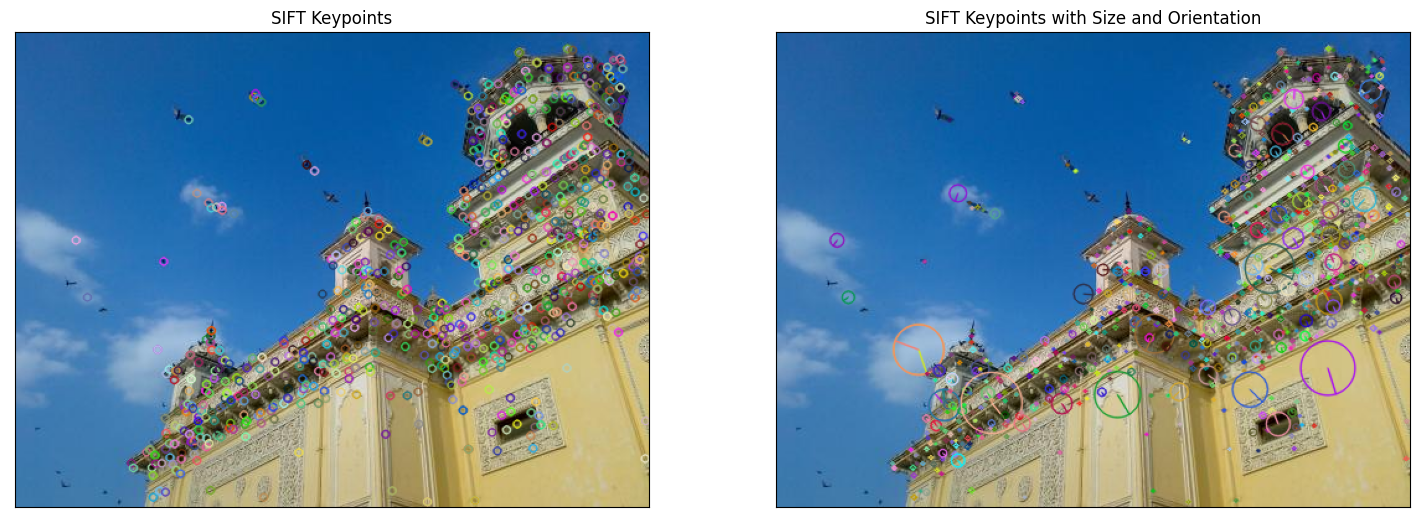

In [3]:
# Read in an image and convert it to grayscale
img = cv.imread('../data/home.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Create a SIFT object
sift = cv.SIFT_create()

# Find keypoints in the 'gray' image
kp = sift.detect(gray, None)

# Draw the keypoints on the image as circles.
# If we supply the flag 'cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS'
# the circle will refect the size of the keypoint,
# and a line will show the orientation of the keypoint.
img2 = cv.drawKeypoints(img.copy(), kp, None)
img3 = cv.drawKeypoints(img.copy(), kp, None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the image together with its keypoints
plt.figure(figsize=(18,18))
plt.subplot(121), plt.imshow(img2[:,:,::-1]), plt.title('SIFT Keypoints'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img3[:,:,::-1]), plt.title('SIFT Keypoints with Size and Orientation'), plt.xticks([]), plt.yticks([]);

Let's see how we can detect keypoints and compute descriptors in one call with the `detectAndCompute()` method. Let's also see what type each keypoint object is, and the shape of the descriptor array.

In [4]:
# Create SIFT object
sift = cv.SIFT_create()

# There are 2 equivalent ways to detect keypoints and compute descriptors:

# A. First detect keypoints, then compute descriptors, as two seperate calls.
kp = sift.detect(gray, None)
kp, des = sift.compute(gray, kp)

# B. Detect keypoints and compute descriptors, in one single call.
kp, des = sift.detectAndCompute(gray, None)

# Print the number of keypoints found,
# the type of a keypoint object,
# and the shape of the descriptor array.
print(f'{len(kp)} keypoints found.')
print(f'Each keypoint is an object of type {type(kp[0])}.')
print(f"The shape of the descriptor array 'des.shape' is {des.shape}.")

885 keypoints found.
Each keypoint is an object of type <class 'cv2.KeyPoint'>.
The shape of the descriptor array 'des.shape' is (885, 128).


Many different algorithms exist for detecting keypoints and creating their descriptors (e.g. SIFT, SURF, ORB, BRISK, MSER). Check the following links for more OpenCV examples with other algorithms:

https://docs.opencv.org/4.6.0/db/d27/tutorial_py_table_of_contents_feature2d.html

## Feature Matching

https://docs.opencv.org/4.6.0/dc/dc3/tutorial_py_matcher.html

Feature Matching is about comparing features in two (or more) images with each other. The simplest (and most inefficient with respect to complexity) feature matching algorithm in OpenCV is the *Brute-Force Matcher*. It works with two sets, $S_1$ and $S_2$ of feature descriptors, where each of the $n_1=|S_1|$ feature descriptors in the first set is compared (matched) with every of the $n_2=|S_2|$ feature descriptors in the second set, using some distance metric, returning the closest match for each of the $n_1=|S_1|$ feature descriptors in the first set. Using OpenCV terminology, the first set $S_1$ is called the *query* set, and the second set $S_2$ is called the *train* set.

First we need to create a *BFMatcher* object using the constructor `bf = cv.BFMatcher()`, which takes 2 optional parameters:
- The first optional parameter `normType` is the normalization type, which specifies the distance metric to use when computing distances. By default, it has a value of `cv.NORM_L2` (i.e. a L2 Norm). This distance metric is good for Euclidean-based feature descriptors, such as SIFT and SURF (a L1 Norm `cv.NORM_L1` can also be used). For binary-string-based descriptors, such as ORB, BRIEF and BRISK, a hamming distance metric `cv.NORM_HAMMING` should be used (if ORB is using `WTA_K == 3` or `WTA_K == 4` then `cv.NORM_HAMMING2` should be used).
- The second optional parameter is a boolean variable `crossCheck`, which is `False` by default. If it's `True`, the matcher only returns matches with value (i,j), such that the $i^{th}$ descriptor in set $S_1$ has the $j^{th}$ descriptor in set $S_2$ as the best match and vice-versa. That is, the two features in both sets should match each other. It provides a consistent result, and is a good alternative to the *ratio test* proposed by David Lowe's SIFT paper.

Once we have a BFMatcher object `bf`, we can call the method `matches = bf.match(des1, des2)` or `knn_matches = bf.knnMatch(des1, des2, k)` that both take the two feature descriptor sets (arrays) `des1` and `des2` as the first and second arguments. The first method `bf.match()` returns the best match (one for each feature descriptor in `des1`). The second method `bf.knnMatch()` returns the $k$ best matches ($k$ for each feature descriptor in `des1`), where `k` is specified as the third argument to the method (it uses the KNN algorithm to do the matching). Therefore, the `bf.match()` function returns list of `cv.DMatch` objects in `matches`, while the `bf.knMatch()` function returns a list of list of `cv.DMatch` objects in `matches` (where the second, innermost list will contain $k$ `cv.DMatch` objects).

The `cv.DMatch` object has the following attributes:
- `distance`: The distance between the two descriptors (lower is better).
- `queryIdx`: The index of the descriptor in the query set (array) `des1`.
- `trainIdx`: The index of the descriptor in train set (array) `des2`.
- `imgIdx`: The index of the train image.

Once we have the `matches`, we can use the two OpenCV functions `img_matches = cv.drawMatches(img_query, kp_query, img_train, kp_train, matches, None, flags)` and `img_matches = cv.drawMatchesKnn(img_query, kp_query, img_train, kp_train, matches, None, flags)` to draw the matches found between the two images (i.e. the query image and the train image). Both functions stack the two images horizontally and draws lines from the first (query) image to the second (train) image, showing the best matching keypoints in the two images. The `cv.drawMatchesKnn()` function will draw $k$ match-lines for each keypoint (we can pass a mask to this function if we only want to select a subset of matches to draw). By default, both functions will draw all keypoints (as circles) in both images. If we only want to draw the keypoints that match between the two images, we can set the `flags` argument to `cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS`. The other arguments passed to the functions are; the *query* image `img_query` and its keypoints `kp_query`, the *train* image `img_train` and its keypoints `kp_train`, the matches found `matches`, and `None` for the output image (since this is already returned as `img_matches` from the function).

Let's see one example of Brute-Force Matching with SIFT Descriptors between two images, a *queryImage* and a *trainImage*, where we will try to find the *queryImage* in *trainImage* using feature matching.

1. First we read in the query image and the train image as grayscale images.
2. Then we create a `cv.SIFT` object and use its `detectAndCompute()` function to obtain the keypoints and descriptors for each image.
3. Next we create the *BFMatcher* object `bf` with the default parameter settings, i.e. using `cv.NORM_L2` as the distance metric (since we are using SIFT keypoints and descriptors) and `crossCheck = False`, which we could turn on `crossCheck = True` for better results.
4. We then call the *BFMatcher* object's `bf.match()` and `bf.knnMatch()` (with $k=2$) functions (to try both functions).
5. We also apply the *ratio test* to the knn (k=2) matches, as explained in David Lowe's paper.
6. Next we sort the matches in ascending order of distance (lower is better), so that the best matches (with small distances) are at the top.
7. Finally, we draw the first 10 best matches to avoid cluttering the visualization (increase the number of draw matches if you like).

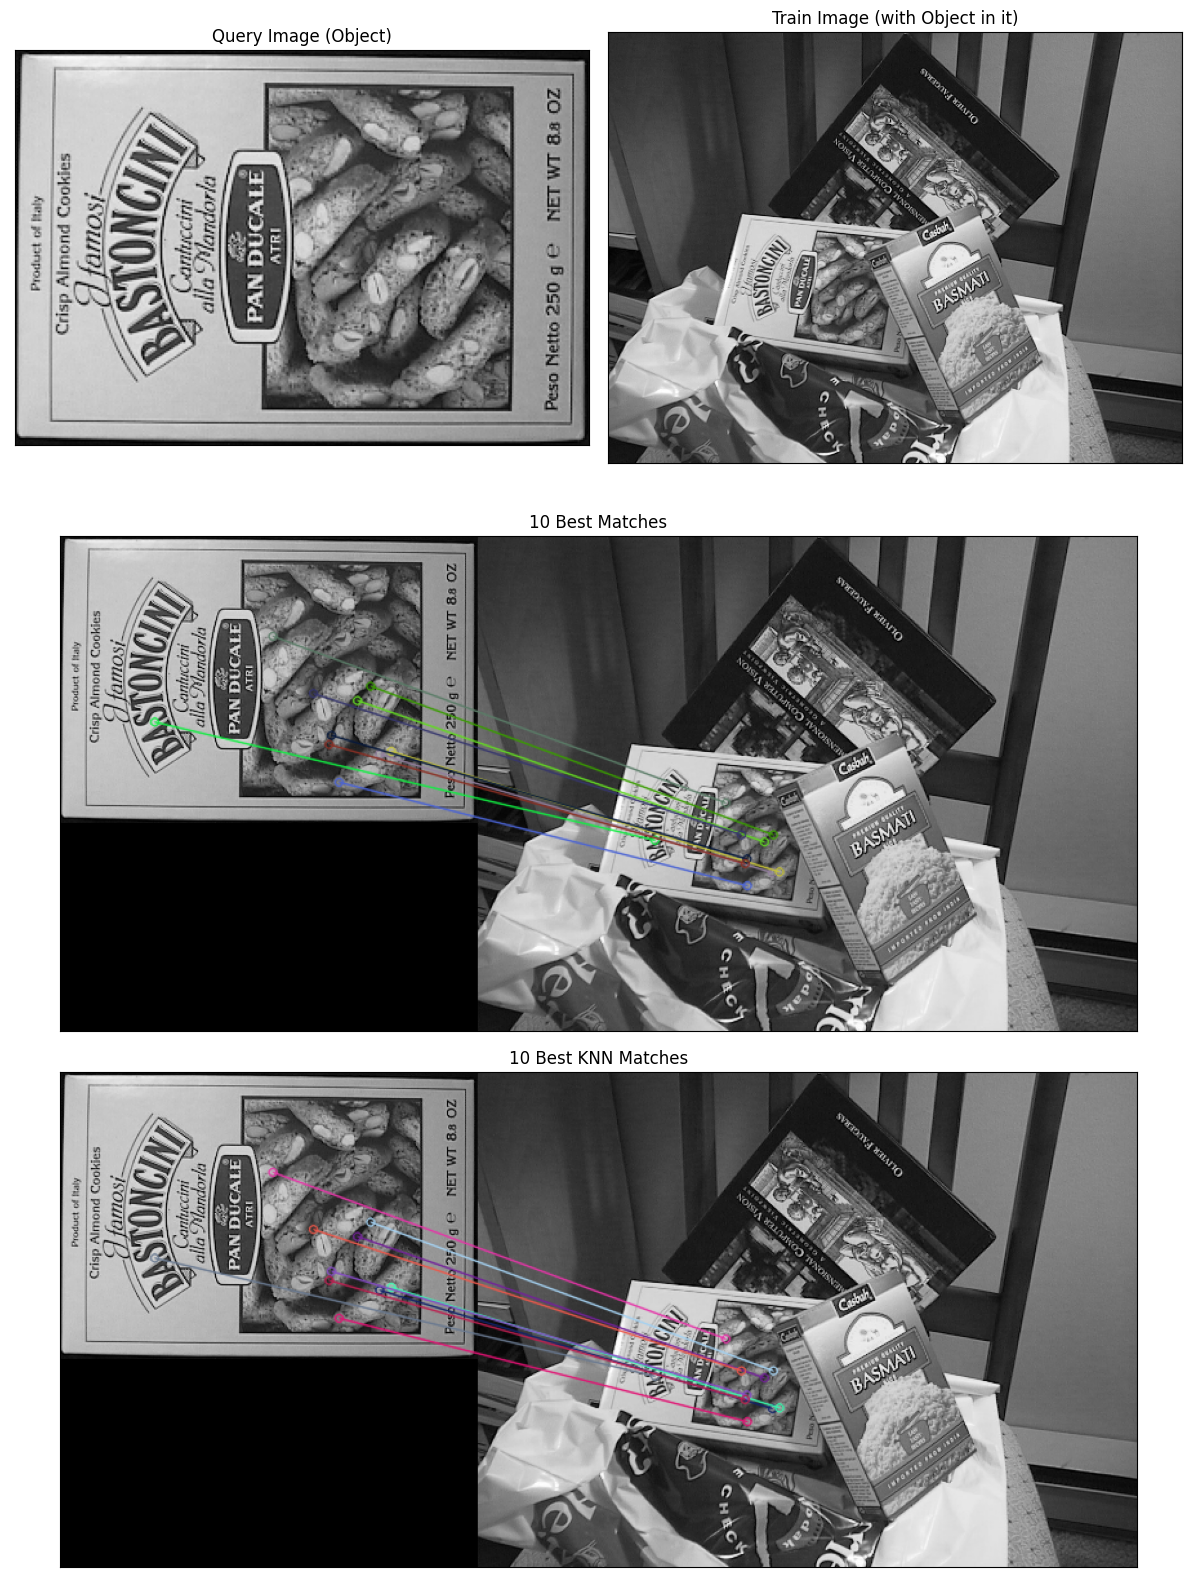

In [5]:
# Read in the query image (containing the object) in grayscale
img_query = cv.imread('../data/box.png', cv.IMREAD_GRAYSCALE)

# Read in the train image (with the above object in it) in grayscale
img_train = cv.imread('../data/box_in_scene.png', cv.IMREAD_GRAYSCALE)

# Create a SIFT detector object
sift = cv.SIFT_create()

# Find the SIFT keypoints and descriptors
# in the query and train images
kp_query, des_query = sift.detectAndCompute(img_query, None)
kp_train, des_train = sift.detectAndCompute(img_train, None)

# Create a Brute Force Matcher (BFMatcher) object (with default parameters)
bf = cv.BFMatcher()
# If we were using ORB, BRIEF or BRISK features, we
# would use a 'cv.NORM_HAMMING' distance metric instead
#bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match the two descriptor sets (arrays) with each other,
# using the simple- and KNN matching algorithms
matches = bf.match(des_query, des_train)
knn_matches = bf.knnMatch(des_query, des_train, k=2) # use k=2

# Sort the matches found by the simple matching
# algorithm in ascending order of distance
sorted_matches = sorted(matches, key = lambda x:x.distance)

# Apply a ratio test to the matches found by the KNN (k=2)
# matching algorithm. Here we only keep the closest match
# if it's less than 75% of the second closest match
# (in David Lowe's paper 80% was used as the threshold).
good_knn_matches = []
for m, n in knn_matches:
    if m.distance < 0.75*n.distance:
        good_knn_matches.append(m)

# Sort the matches found by the filtered KNN matching
# algorithm in ascending order of distance
sorted_good_knn_matches = sorted(good_knn_matches, key = lambda x:x.distance)

# Draw the first 10 matches found by the simple matching algorithm.
img_matches = cv.drawMatches(img_query, kp_query, img_train, kp_train, sorted_matches[:10], None,
                      flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Draw the first 10 matches found by the filtered KNN matching algorithm.
# Note: 'cv.drawMatchesKnn' expects a list of lists as matches.
sorted_good_knn_matches = [[m] for m in sorted_good_knn_matches]
img_matches_knn = cv.drawMatchesKnn(img_query, kp_query, img_train, kp_train, sorted_good_knn_matches[:10], None,
                         flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot the query image and train image, together with
# the stacked images with added keypoints and matches
plt.figure(figsize=(12,16))

plt.subplot(321), plt.imshow(img_query, cmap="gray"), plt.title('Query Image (Object)'), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(img_train, cmap="gray"), plt.title('Train Image (with Object in it)'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_matches), plt.title('10 Best Matches'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(img_matches_knn), plt.title('10 Best KNN Matches'), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

For an example of a *Fast Library for Approximate Nearest Neighbors (FLANN)*-based Matcher, check the links below. 

https://docs.opencv.org/4.6.0/dc/dc3/tutorial_py_matcher.html

For an example of a *FLANN*-based Matcher with *Homography* to find objects, check the links below. 

https://docs.opencv.org/4.6.0/d1/de0/tutorial_py_feature_homography.html